In [6]:
import pandas as pd
import numpy as np
import cv2

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks
 

In [7]:
data = np.load(r'Finger_rgb\001_dedo_rgb_data.npz')
print(data.files)


['red', 'green', 'blue']


In [9]:

green = data['green']
red = data['red']
blue = data['blue']

print(red.shape)
print(red[:20])

print(green.shape)
print(green[:20])

print(blue.shape)
print(blue[:20])







(21111,)
[226.12684124 225.86075762 225.6023206  225.54525704 225.43171489
 225.43849826 225.45027922 225.44508439 225.45333767 225.28287809
 225.2504075  225.21284915 225.20337384 225.1971523  225.22225598
 225.27074363 225.29778019 225.32365066 225.34822772 225.38057002]
(21111,)
[61.23495274 60.89611642 60.52989198 60.33539593 60.24803048 60.20924093
 60.20702112 60.21720631 60.24739632 60.27421103 60.24542872 60.23441165
 60.2555652  60.29068625 60.35525945 60.43939525 60.49826244 60.56170042
 60.61270882 60.67852141]
(21111,)
[26.41442033 26.3729104  26.36918981 26.56680604 26.50026427 26.6233343
 26.6878178  26.71507668 26.73875627 26.48486304 26.46678482 26.44720679
 26.40574653 26.39562066 26.38397087 26.39233121 26.36842255 26.35714024
 26.33014516 26.30282697]


In [33]:
data.close()

In [2]:
def extract_rgb(video_path):
    # Abrir el video
    cap = cv2.VideoCapture(video_path)
    
    # Verificar si el video fue abierto correctamente
    if not cap.isOpened():
        print("Error al abrir el archivo de video.")
        return
    
    # Obtener la tasa de frames por segundo (FPS) del video
    fps = cap.get(cv2.CAP_PROP_FPS)
    print(f"FPS del video: {fps}")
    
    # Calcular el número de frames para los primeros 30 segundos
    frames_to_capture = int(30 * fps)
    
    frame_count = 0
    
    while frame_count < frames_to_capture:
        ret, frame = cap.read()
        if not ret:
            print("Error al leer el frame o fin del video.")
            break
        
        # Incrementar contador de frames
        frame_count += 1
        
        # OpenCV captura imágenes en BGR, convertir a RGB
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Calcular el valor promedio de cada canal RGB
        avg_color_per_row = np.average(rgb_frame, axis=0)
        avg_color = np.average(avg_color_per_row, axis=0)
        avg_red = avg_color[0]
        avg_green = avg_color[1]
        avg_blue = avg_color[2]
        
        # Imprimir los valores RGB promedio del frame actual
        print(f"Frame {frame_count}: R={avg_red:.2f}, G={avg_green:.2f}, B={avg_blue:.2f}")
    
    # Liberar el capturador y cerrar todas las ventanas
    cap.release()
    cv2.destroyAllWindows()

# Llamar a la función con la ruta al video
video_path = r'DB\003_dedo.mp4'
extract_rgb(video_path)

FPS del video: 30.0
Frame 1: R=195.32, G=0.00, B=5.48
Frame 2: R=195.28, G=0.00, B=5.46
Frame 3: R=195.11, G=0.00, B=5.43
Frame 4: R=195.02, G=0.00, B=5.44
Frame 5: R=194.99, G=0.00, B=5.44
Frame 6: R=194.98, G=0.00, B=5.45
Frame 7: R=194.98, G=0.00, B=5.45
Frame 8: R=195.01, G=0.00, B=5.45
Frame 9: R=195.04, G=0.00, B=5.44
Frame 10: R=195.19, G=0.00, B=5.47
Frame 11: R=195.20, G=0.00, B=5.45
Frame 12: R=195.19, G=0.00, B=5.44
Frame 13: R=195.13, G=0.00, B=5.41
Frame 14: R=195.25, G=0.00, B=5.43
Frame 15: R=195.37, G=0.00, B=5.43
Frame 16: R=195.54, G=0.00, B=5.44
Frame 17: R=195.52, G=0.00, B=5.38
Frame 18: R=195.63, G=0.00, B=5.39
Frame 19: R=195.64, G=0.00, B=5.38
Frame 20: R=195.70, G=0.00, B=5.37
Frame 21: R=195.56, G=0.00, B=5.29
Frame 22: R=195.29, G=0.00, B=5.25
Frame 23: R=195.04, G=0.00, B=5.24
Frame 24: R=194.98, G=0.00, B=5.26
Frame 25: R=195.03, G=0.00, B=5.28
Frame 26: R=195.02, G=0.00, B=5.28
Frame 27: R=195.09, G=0.00, B=5.28
Frame 28: R=195.21, G=0.00, B=5.31
Frame 29:

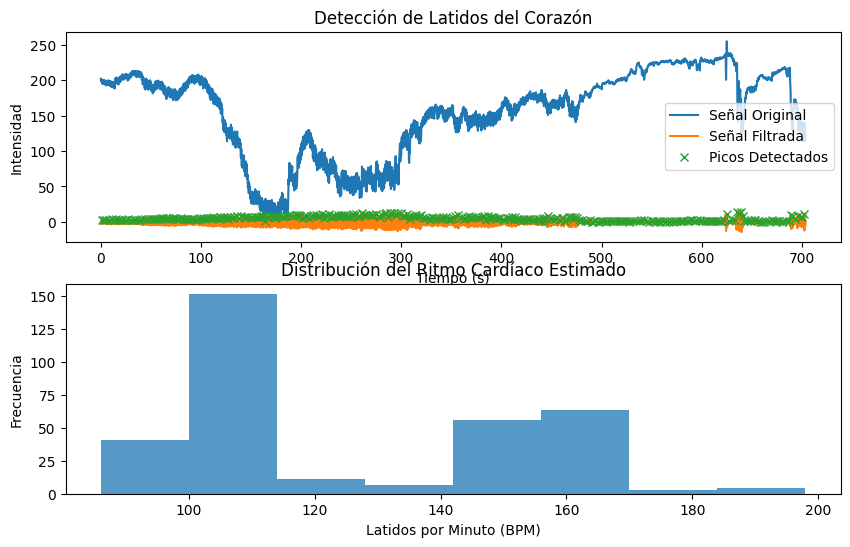

Estimación del Ritmo Cardíaco: 28.91 latidos por minuto


In [15]:
# Configuración del filtro
fs = 30.0  # Frecuencia de muestreo
lowcut = 0.7
highcut = 1.6

# Longitud de la señal
n_samples = len(green)

# Tiempo total de la señal
total_time = n_samples / fs

green_min = green.min()
green_max = green.max()

# Normalización lineal
green = (green - green_min) / (green_max - green_min) * 255

# Crear el array de tiempo t
t = np.linspace(0, total_time, n_samples, endpoint=False)
# Filtrar la señal
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y



# Aplicar filtro
filtered_signal = butter_bandpass_filter(green, lowcut, highcut, fs, order=6)

# Detectar picos
peaks, _ = find_peaks(filtered_signal, distance=fs/lowcut)

# Calcular los intervalos RR
rr_intervals = np.diff(peaks) / fs

# Estimar la frecuencia cardíaca
heart_rate = 60 / np.mean(rr_intervals) if len(rr_intervals) > 0 else 0

# Visualización
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, green, label='Señal Original')
plt.plot(t, filtered_signal, label='Señal Filtrada')
plt.plot(peaks/fs, filtered_signal[peaks], "x", label='Picos Detectados')
plt.title('Detección de Latidos del Corazón')
plt.xlabel('Tiempo (s)')
plt.ylabel('Intensidad')
plt.legend()

plt.subplot(2, 1, 2)
plt.hist(rr_intervals * 60, bins=8, alpha=0.75) if len(rr_intervals) > 0 else None
plt.title('Distribución del Ritmo Cardíaco Estimado')
plt.xlabel('Latidos por Minuto (BPM)')
plt.ylabel('Frecuencia')
plt.show()

print("Estimación del Ritmo Cardíaco: {:.2f} latidos por minuto".format(heart_rate))

In [11]:
# imprime que tipo de dato es green
print(type(green))

<class 'numpy.ndarray'>


In [20]:
def initialize_face_rect(frame):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    if len(faces) > 0:
        # Tomar la primera cara detectada (puedes mejorar esto para manejar múltiples caras)
        x, y, w, h = faces[0]
        return (x, y, w, h)
    else:
        # Si no se detecta ninguna cara, devuelve un rectángulo predeterminado
        return (50, 50, frame.shape[1] - 100, frame.shape[0] - 100)

# Cargar el video
video_path = r'DB\002.mp4'
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Error al abrir el video.")
    exit(0)

# Leer el primer frame
ret, frame = cap.read()
if not ret:
    print("No se pudo leer el video")
    cap.release()
    exit(0)

# Inicializar el rectángulo de la cara
rect = initialize_face_rect(frame)

# Configuraciones de GrabCut
mask = np.zeros(frame.shape[:2], dtype=np.uint8)
bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)
cv2.grabCut(frame, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

# Convertir la máscara de GrabCut
mask2 = np.where((mask == 2)|(mask == 0), 0, 1).astype('uint8')
skin = frame * mask2[:, :, np.newaxis]

# Mostrar el resultado del primer frame
cv2.imshow('Skin', skin)
cv2.waitKey(0)

cap.release()
cv2.destroyAllWindows()